# ACID vs CAP theorem
## ACID (mostly rational databases)
- Guarantees safe, stable transactions.
	- **A**tomicity/ˌætə'mɪsɪti/: all or nothing, one of the operations in transaction fall, roll all back before the transaction
	- **C**onsistency: data always valid
	- **I**solation: transactions don’t affect each other
	- **D**urability: changes survive crashes

- Example: bank transfer must complete fully or not at all.
> frequently asked question in interviews, better to explain in yours own words

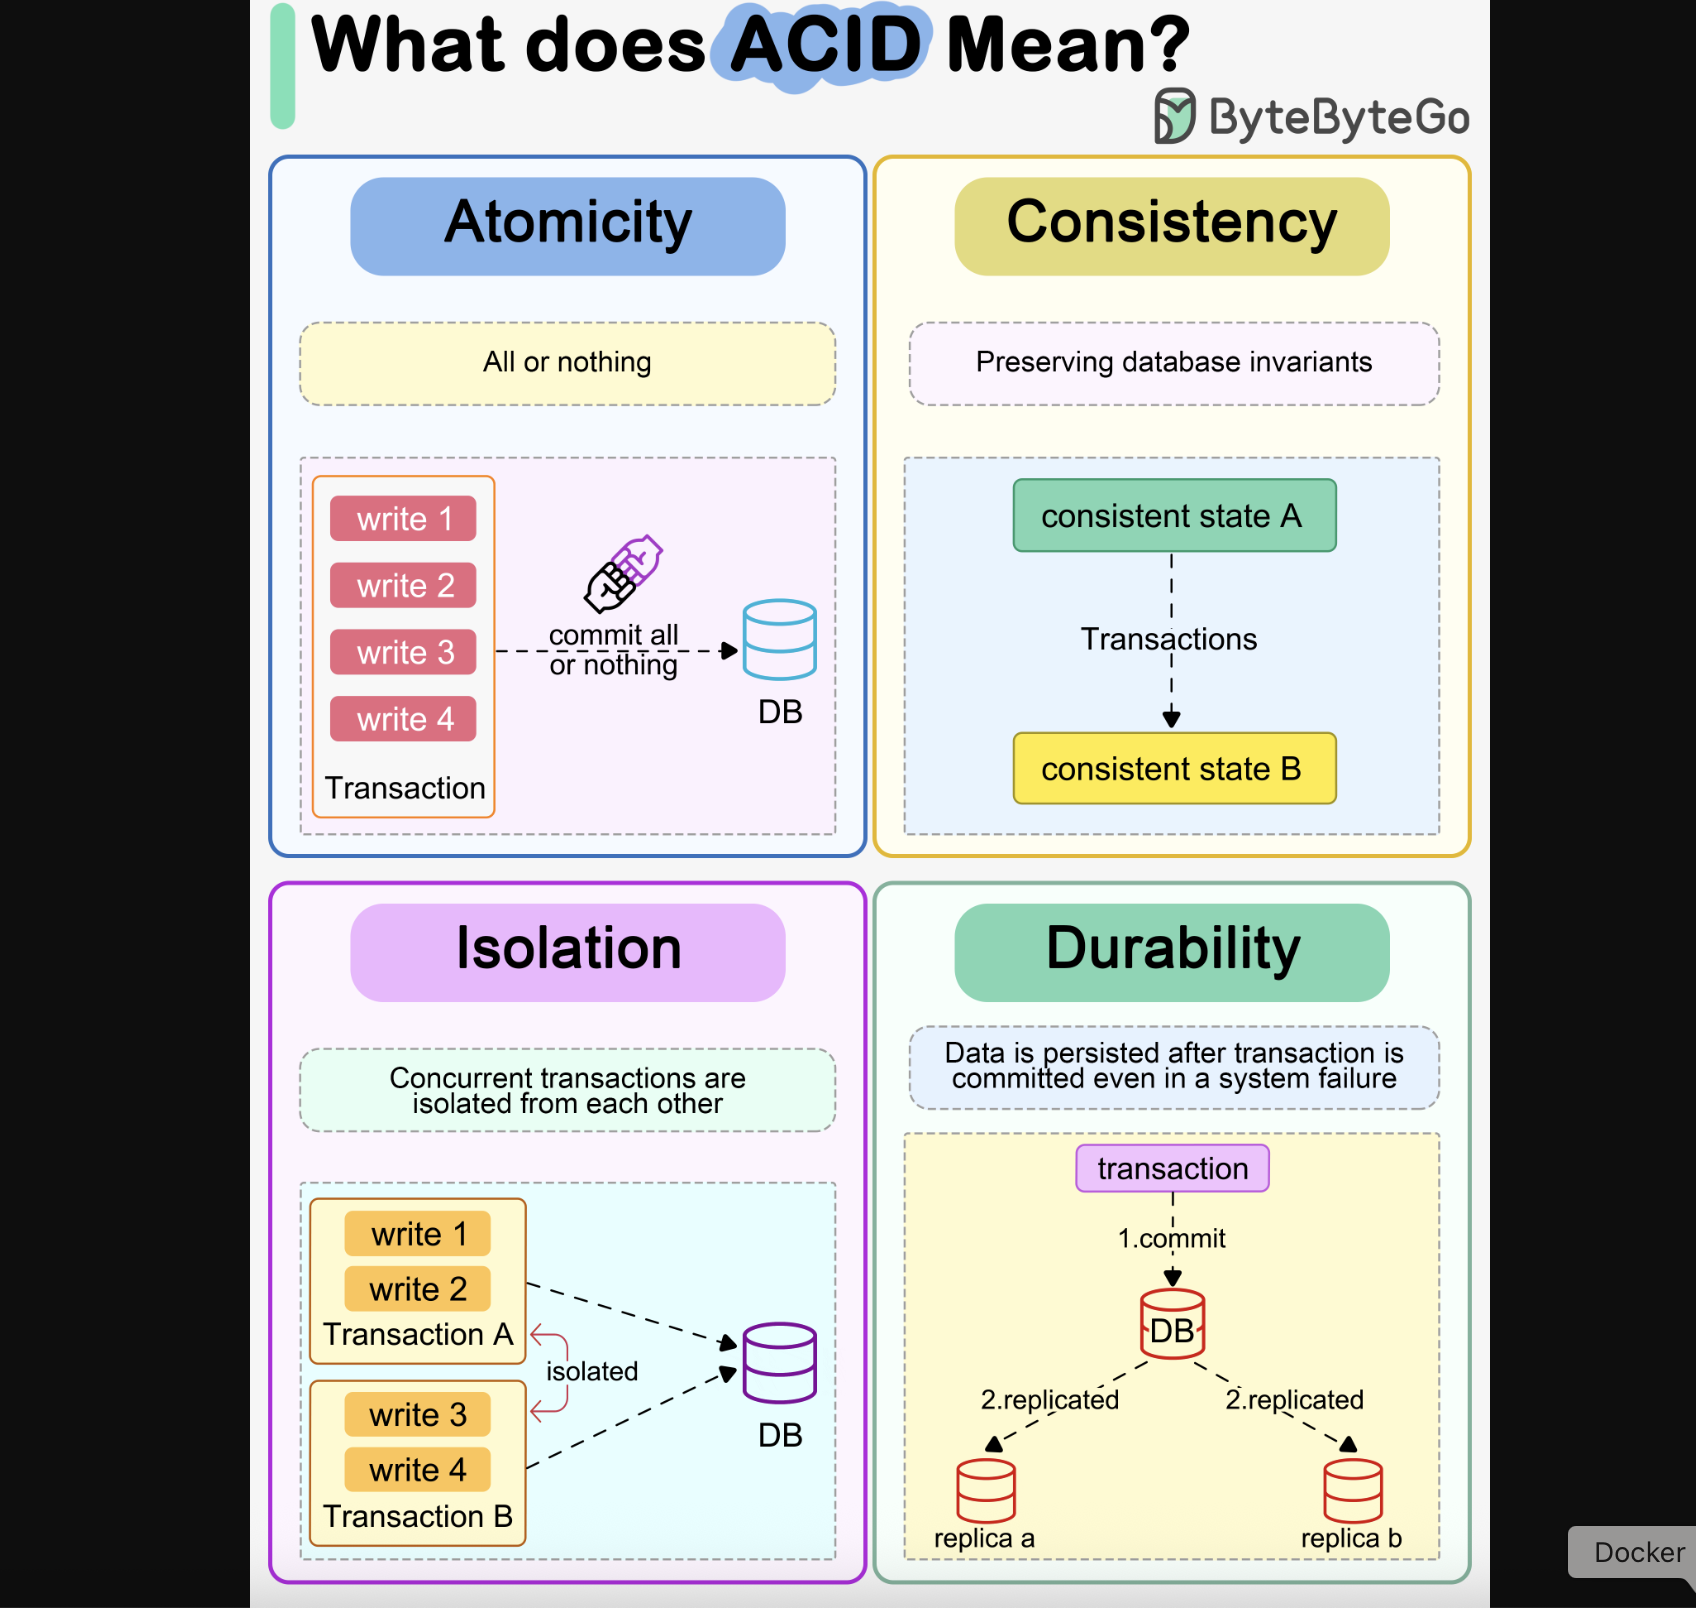
[original pic](https://assets.bytebytego.com/diagrams/0407-what-does-acid-mean.png)

### Atomicity
A transaction is all-or-nothing. **Either all operations in the transaction complete successfully, or none of them do**. If something fails halfway through, everything **rolls back** to the initial state.

### Consistency
Transactions move the database **from one valid state to another**, maintaining all defined rules, constraints, and relationships. The database **never ends up in an inconsistent state**.

### Isolation
Concurrent transactions don't interfere with each other. Each transaction executes **as if it's the only one running**, even when multiple transactions are happening simultaneously.

### Durability 耐用性
Once a transaction is **committed, it's permanent**. Even if the system crashes immediately after, the changes persist

## CAP Theorem (**distributed systems** NoSQL)
- A distributed system can **only guarantee 2 out of 3**:
	- **C**onsistency: everyone sees the same data
	- **A**vailability: system always responds
	- **P**artition-tolerance: system works even if network splits

- Example:
	- **CP** (MongoDB in strong mode): consistent but maybe not always available
	- **AP** (Cassandra): always available, but might return slightly old data

### C - Consistency
Every read receives **the most recent write or an error**. All nodes see the **same data at the same time**.

| Model | Consistency | Availability | Latency | Use Case |
|-------|-------------|--------------|---------|----------|
| Strong | Highest | Lowest | Highest | Financial systems |
| Eventual | Medium | Highest | Low | Social media |
| Weak | Lowest | Highest | Lowest | Real-time streaming |

### A - Availability
**Every request receives a response (success or failure)**, even if some nodes are down. The system continues operating without complete data.

### P - Partition Tolerance
The system continues to operate despite network partitions (communication breakdowns between nodes). In real distributed systems, partitions will happen, so this is **non-negotiable**. So the real choice becomes AP or CP.

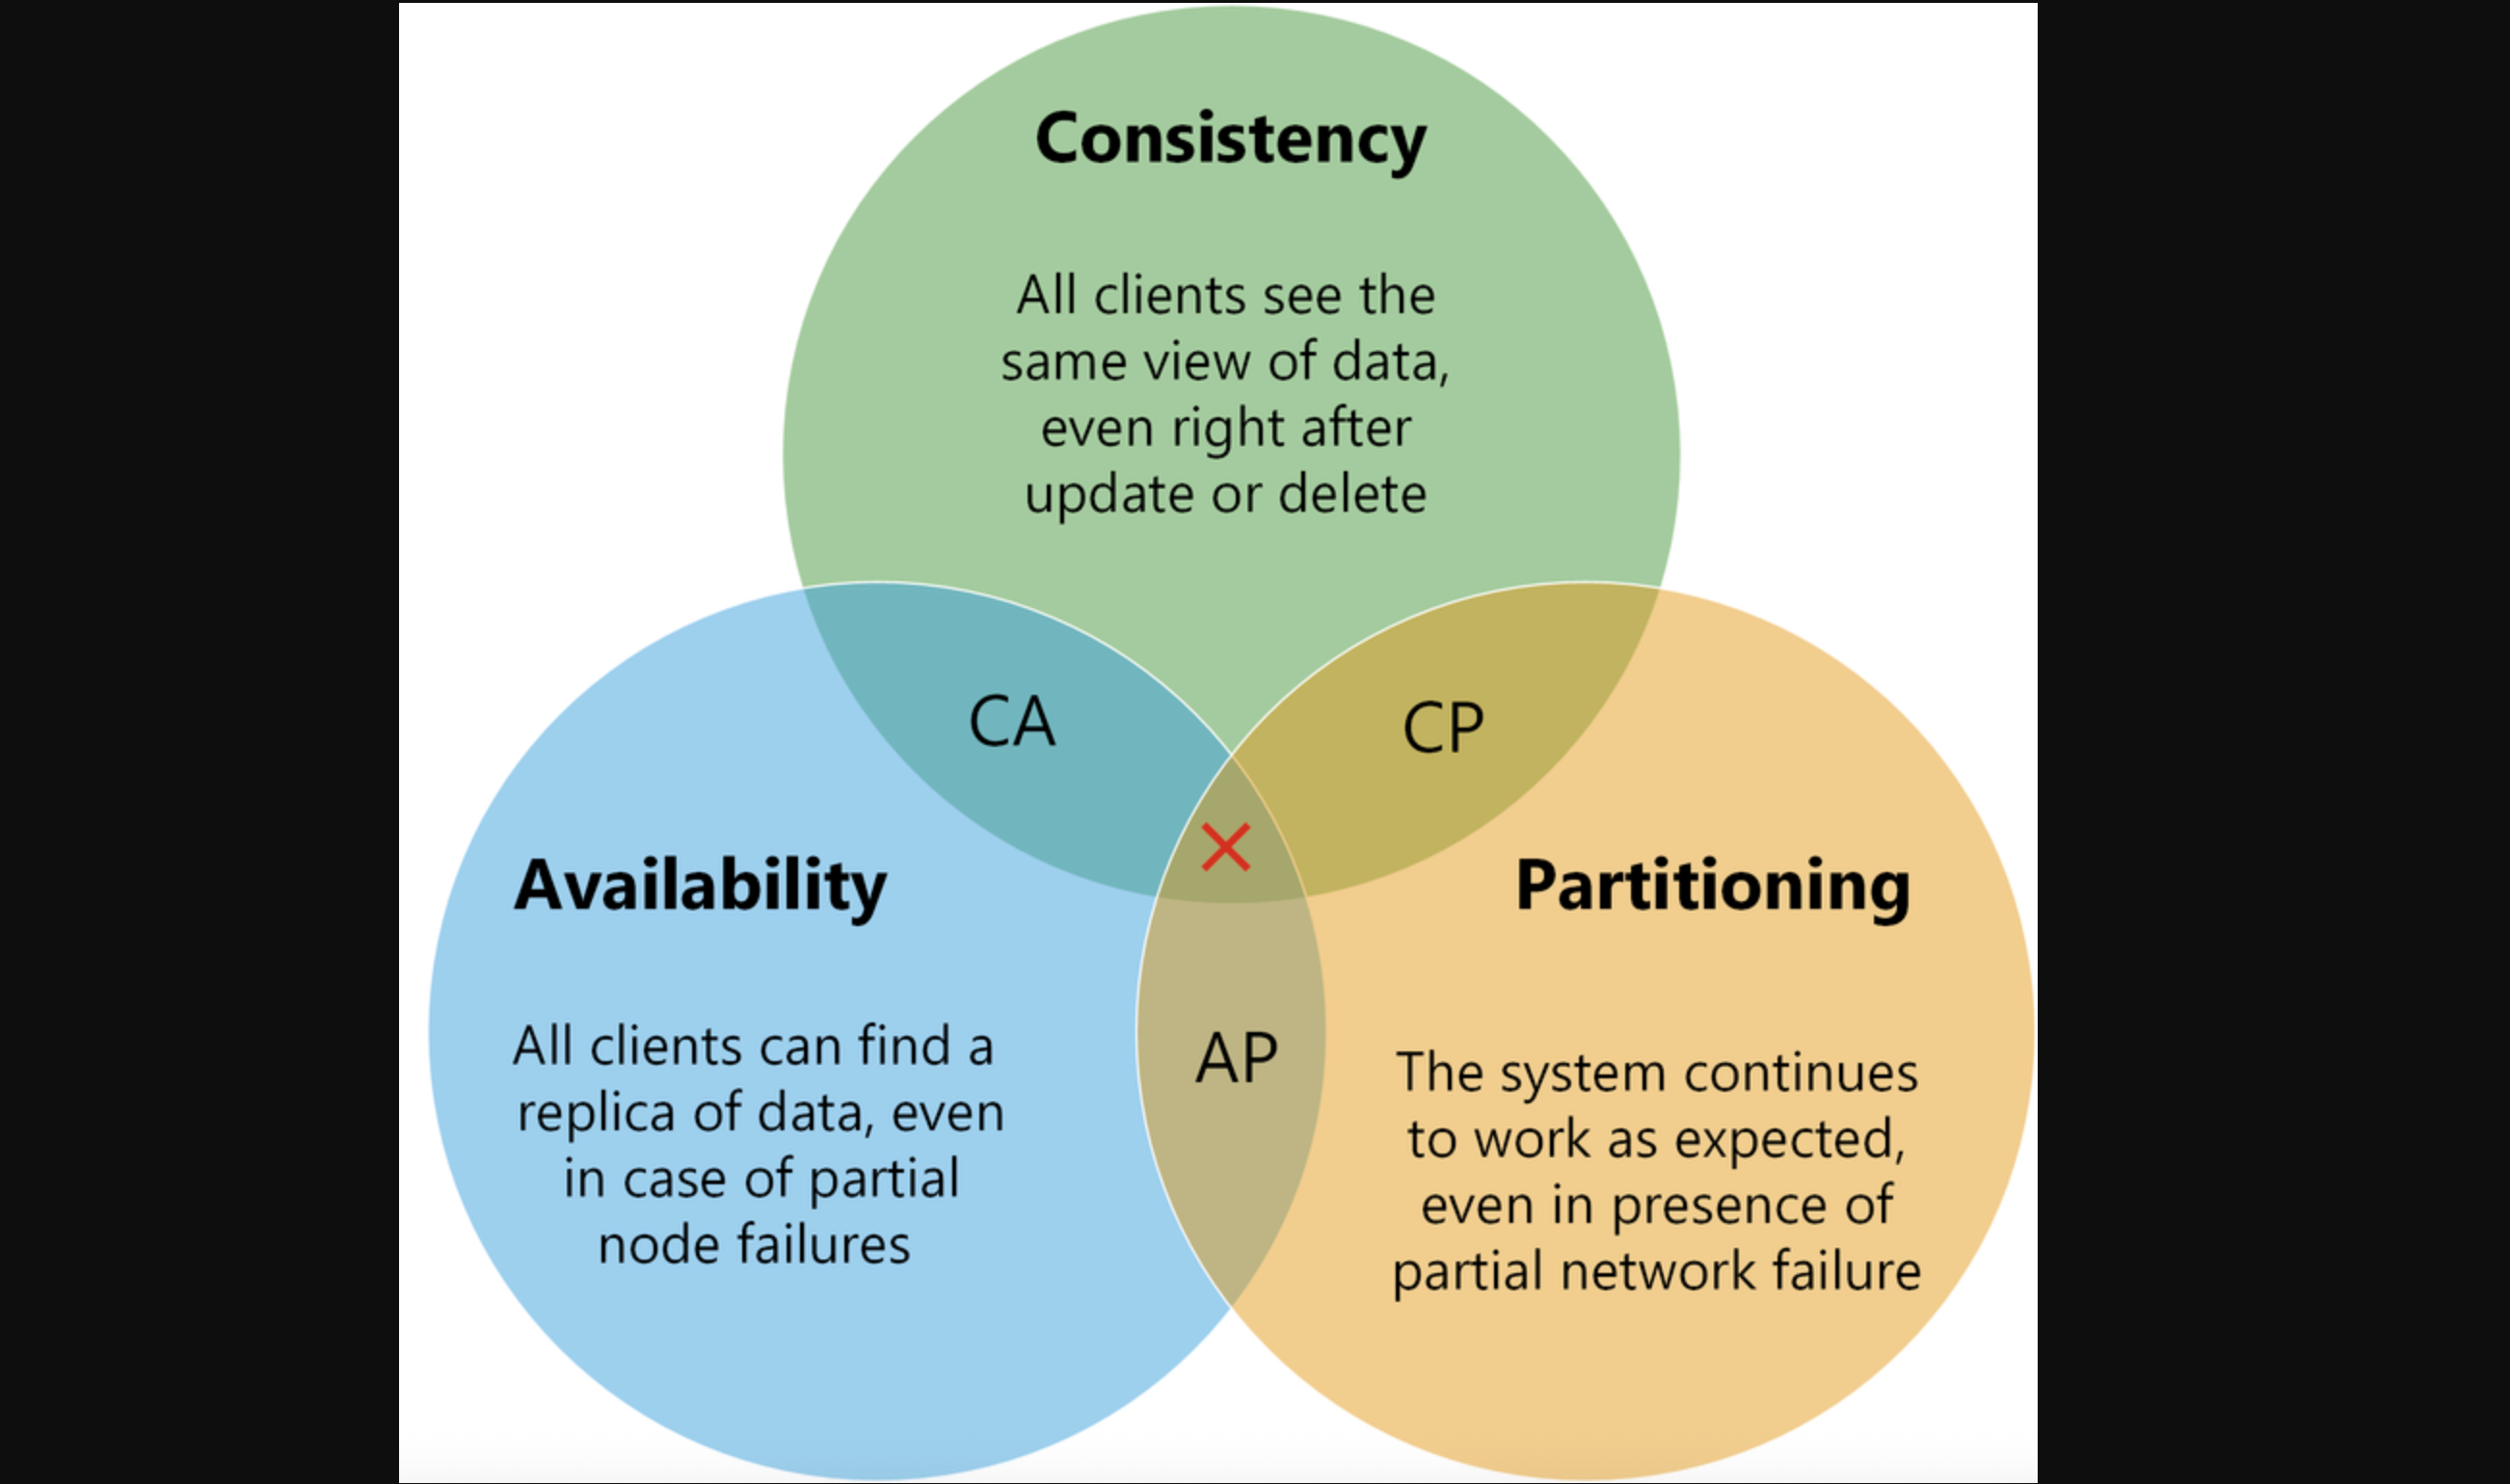

### 🧩 What Partition Tolerance Really Means

**Partition tolerance = the system keeps running even when parts of the network can’t talk to each other.**  

Imagine your distributed system is made of many servers (nodes).
A network partition is when some servers become unable to communicate with the rest—maybe because:
	•	A network cable broke   
	•	A data center lost connectivity   
	•	A switch failed    
	•	A temporary congestion timeout happened    

Partition tolerance says:    

Even if the network splits into two (or more) isolated islands, the system should continue functioning, not crash.    

⸻

#### 🛑 Why It’s Non-Negotiable
   
Because in any real distributed system, **partitions will happen eventually.** You can’t avoid them. The internet is messy.    

So in the CAP theorem:   
	•	You **must choose P**, because you can’t turn off partitions.   
	•	The “real” choice becomes C vs A during a partition.    

⸻  
  
🎭 **Simple Example**   

Scenario    

Your system has 3 nodes: A, B, C.   

Suddenly A and B can talk to each other,    
but C is isolated due to a network failure.     
A <-----> B     || break ||     C     

A partition occurred.     

A partition-tolerant system must still work while A/B and C are disconnected.     

But this creates a dilemma:    
	•	If both sides take writes → they may diverge → lose **Consistency**   
	•	If one side rejects writes until the partition heals → loses **Availability**   

This is why you can’t have all 3 (C + A + P) at the same time.    

⸻

🏡 **Real-World Analogy**    

Think of a company with two offices.The internet between them goes down.    

Partition tolerance means:   
Each office should keep operating locally, not shut down because they can’t reach HQ.    

⸻

💡 **The Key Idea**    

You don’t “enable” or “choose” partition tolerance.     
You **must handle partitions, because they are inevitable**.    

The real choice is:    
	•	**CP** system → prefer Consistency       
Pause or reject some requests during partition       
(e.g., Zookeeper, Etcd)       
	•	**AP** system → prefer Availability      
Allow operations on isolated nodes → resolve conflicts later     
(e.g., Cassandra, DynamoDB)     

# Performance improvement for SQL (analysis)
## 0. Most important way to measure / analyze performance
   - EXPLAIN ANALYZE (mysql, postgres, not allowed in mssql)
   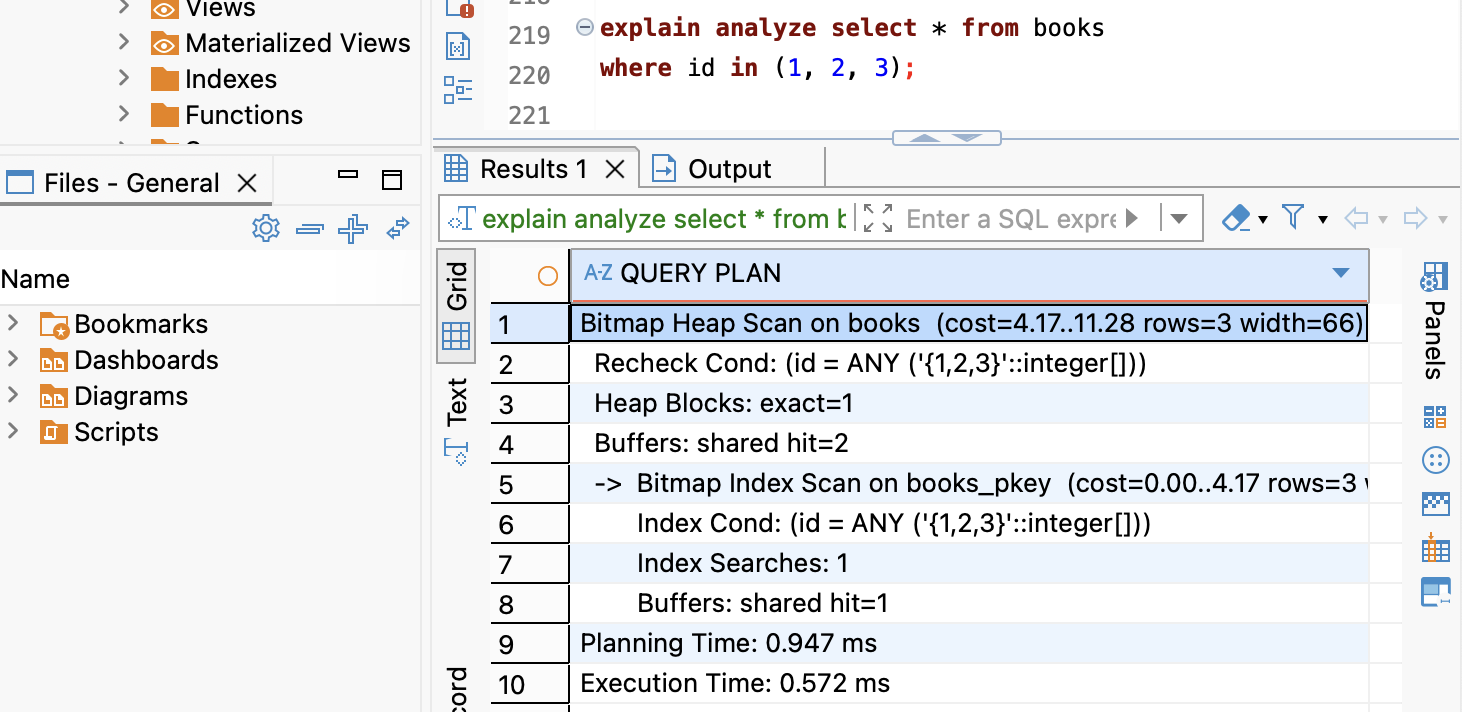
   - add monitor ro monitor the querying performance (from third party platform like Datadog)

## 1. Add proper indexes
   ```sql
   CREATE INDEX idx_customer_id ON orders(customer_id);
   ```
### Pros
- Dramatic performance improvements (100x-1000x faster)
- Easy to implement (one SQL statement)
- No application changes needed
- Low risk
- Immediate impact

### Cons
- Slower writes (index must be updated on INSERT/UPDATE/DELETE)
- Uses disk space (can be substantial for large tables)
- Too many indexes hurt performance
- Need to maintain/rebuild periodically
- Wrong index doesn't help (or makes things worse)

### When to Use
- **First solution** for slow queries
- Queries scanning many rows
- Frequent WHERE, JOIN, ORDER BY operations
- Before considering more complex solutions

### When NOT to Use
- Table has mostly writes, few reads
- Columns with low cardinality (e.g., boolean fields)
- Already have 5+ indexes on the table
- Query needs full table scan anyway

## 2. Read Replicas
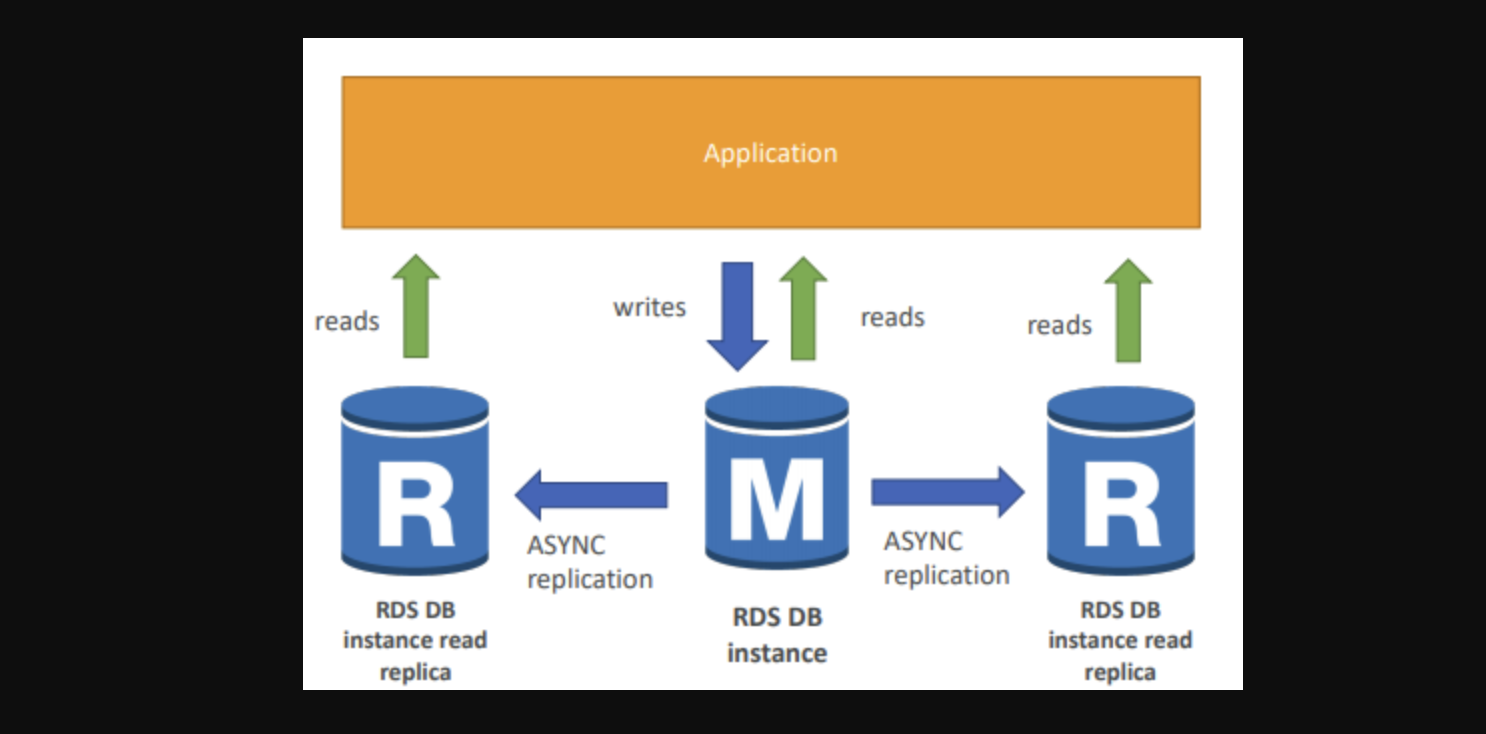
[pic](https://miro.medium.com/1*NMt7vXbqH34hNJLHVU2d-A.png)

### Pros
- Scales read capacity horizontally (add more replicas)
- Reduces load on primary database
- Improves read latency (replicas closer to users)
- High availability (failover if primary dies)
- Can use replicas for backups, analytics
- Relatively simple to implement
### Cons
- Replication lag (replicas slightly behind primary)
- Application must route reads vs writes
- Doesn't help with write-heavy workloads
- More infrastructure to manage
- Stale reads possible
- Costs (running multiple servers)

### When to Use

- Read-heavy workloads (90%+ reads)
- Primary database CPU maxed out from reads
- Need geographic distribution
- Want high availability
- Analytics queries interfere with production

### When NOT to Use
- Write-heavy workload
- Strong consistency required everywhere
- Single-server can handle current load
- Budget constrained


## 3. Caching
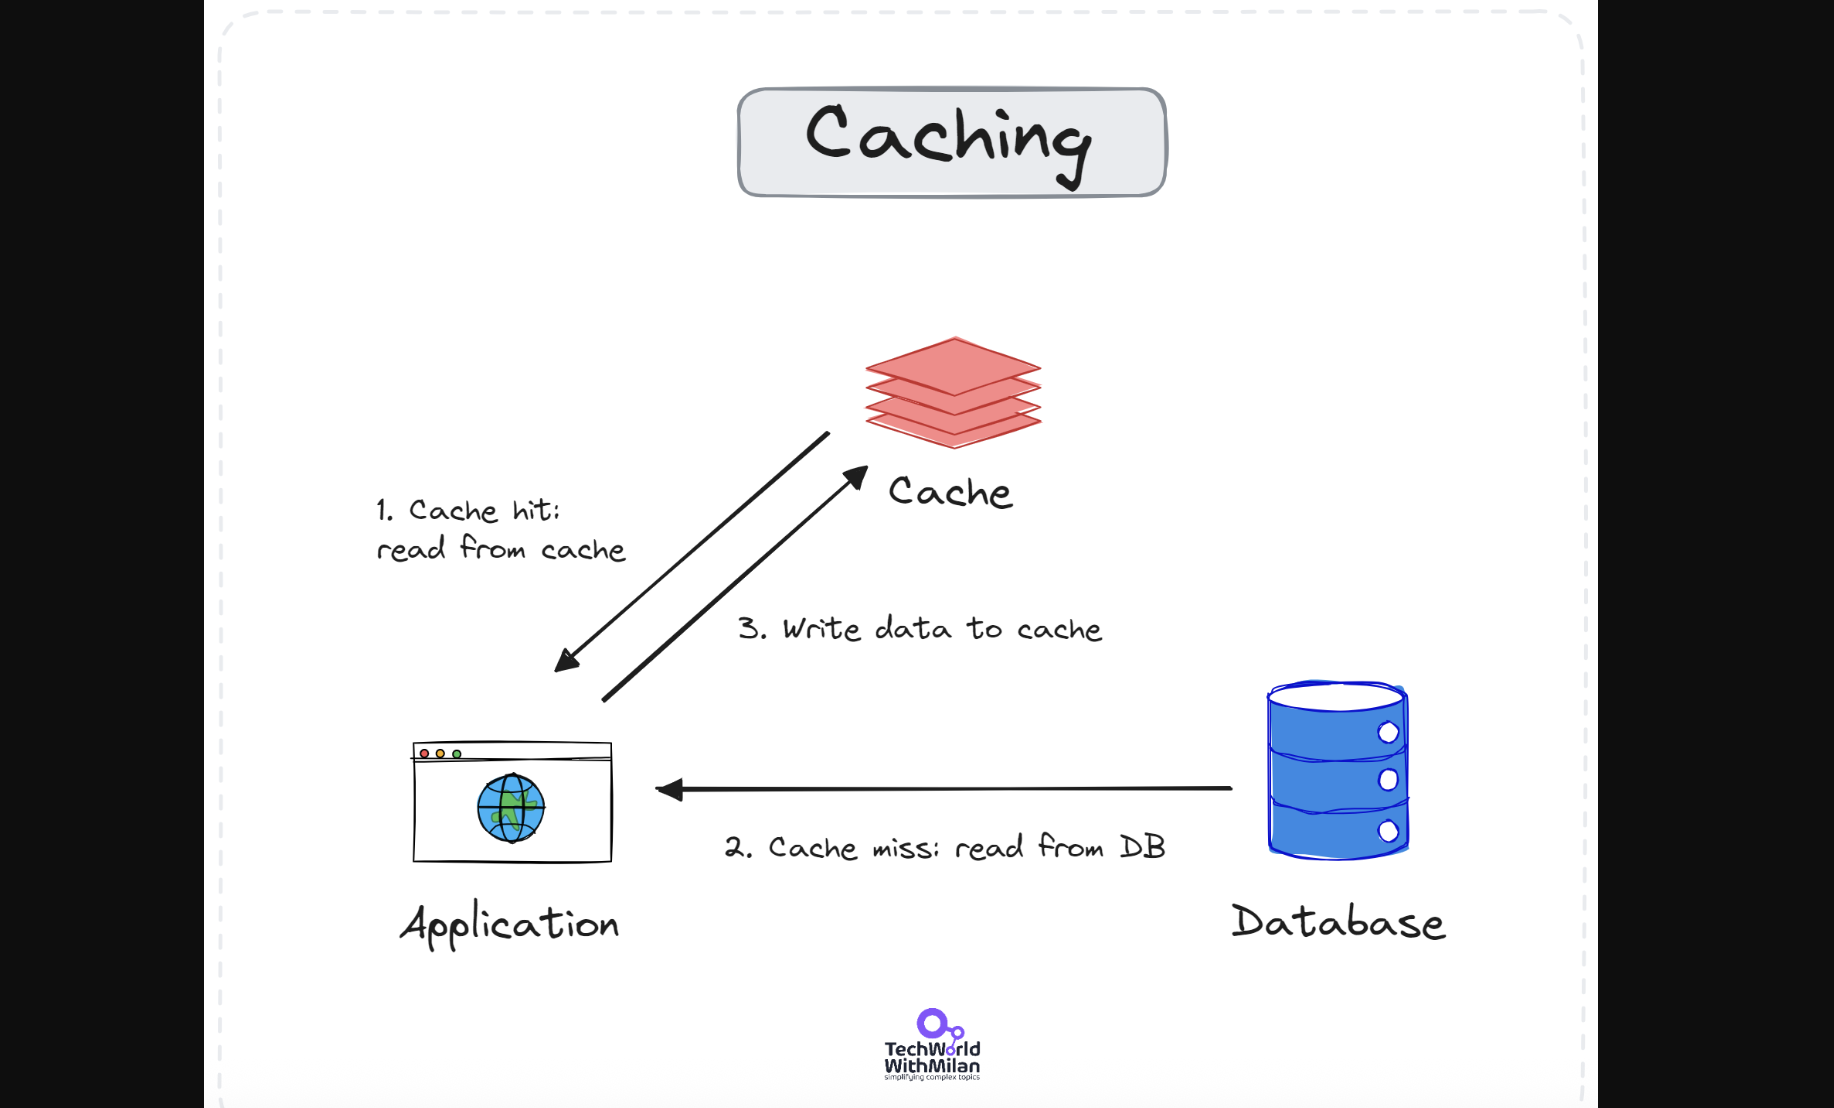
[pic](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F6939442a-fa84-44ae-8ec7-09c605ae32c9_1804x1494.png)

### Common Tools:
- Redis: In-memory key-value store, pub/sub, data structures
- Memcached: Simple key-value cache

### Pros
- Massive performance improvement (10-100x faster)
- Reduces database load dramatically
- Scales horizontally

### Cons
- Cache invalidation is hard
- Stale data possible
- Added complexity (what to cache, how long, invalidation)

### When to Use

- Read-heavy with frequent repeated queries
- Expensive queries (complex joins, aggregations)
- Hot data (20% of data, 80% of requests)
- High traffic with mostly static data

### When NOT to Use

- Data must always be perfectly fresh
- Write-heavy workload

## 4. Materialized views

### Pros
- Dramatic query speedup (minutes → milliseconds)
- Reduces CPU load and I/O on source tables
- Transparent to application (queries like regular tables)
- Can add indexes for further optimization

### Cons
- Stale data (only current as of last refresh)
- Storage overhead (duplicates data)
- Refresh can be expensive and slow
- Standard refresh blocks queries (use CONCURRENTLY to avoid)

### When to Use:

- Reporting and analytics dashboards
- Complex aggregations run frequently
- Read-heavy workloads where slight staleness is acceptable
- Expensive queries that don't need real-time data

### When NOT to Use:

- You need real-time data
- Data changes very frequently
- The underlying query is already fast
- Storage is limited


## 5. Partitioning
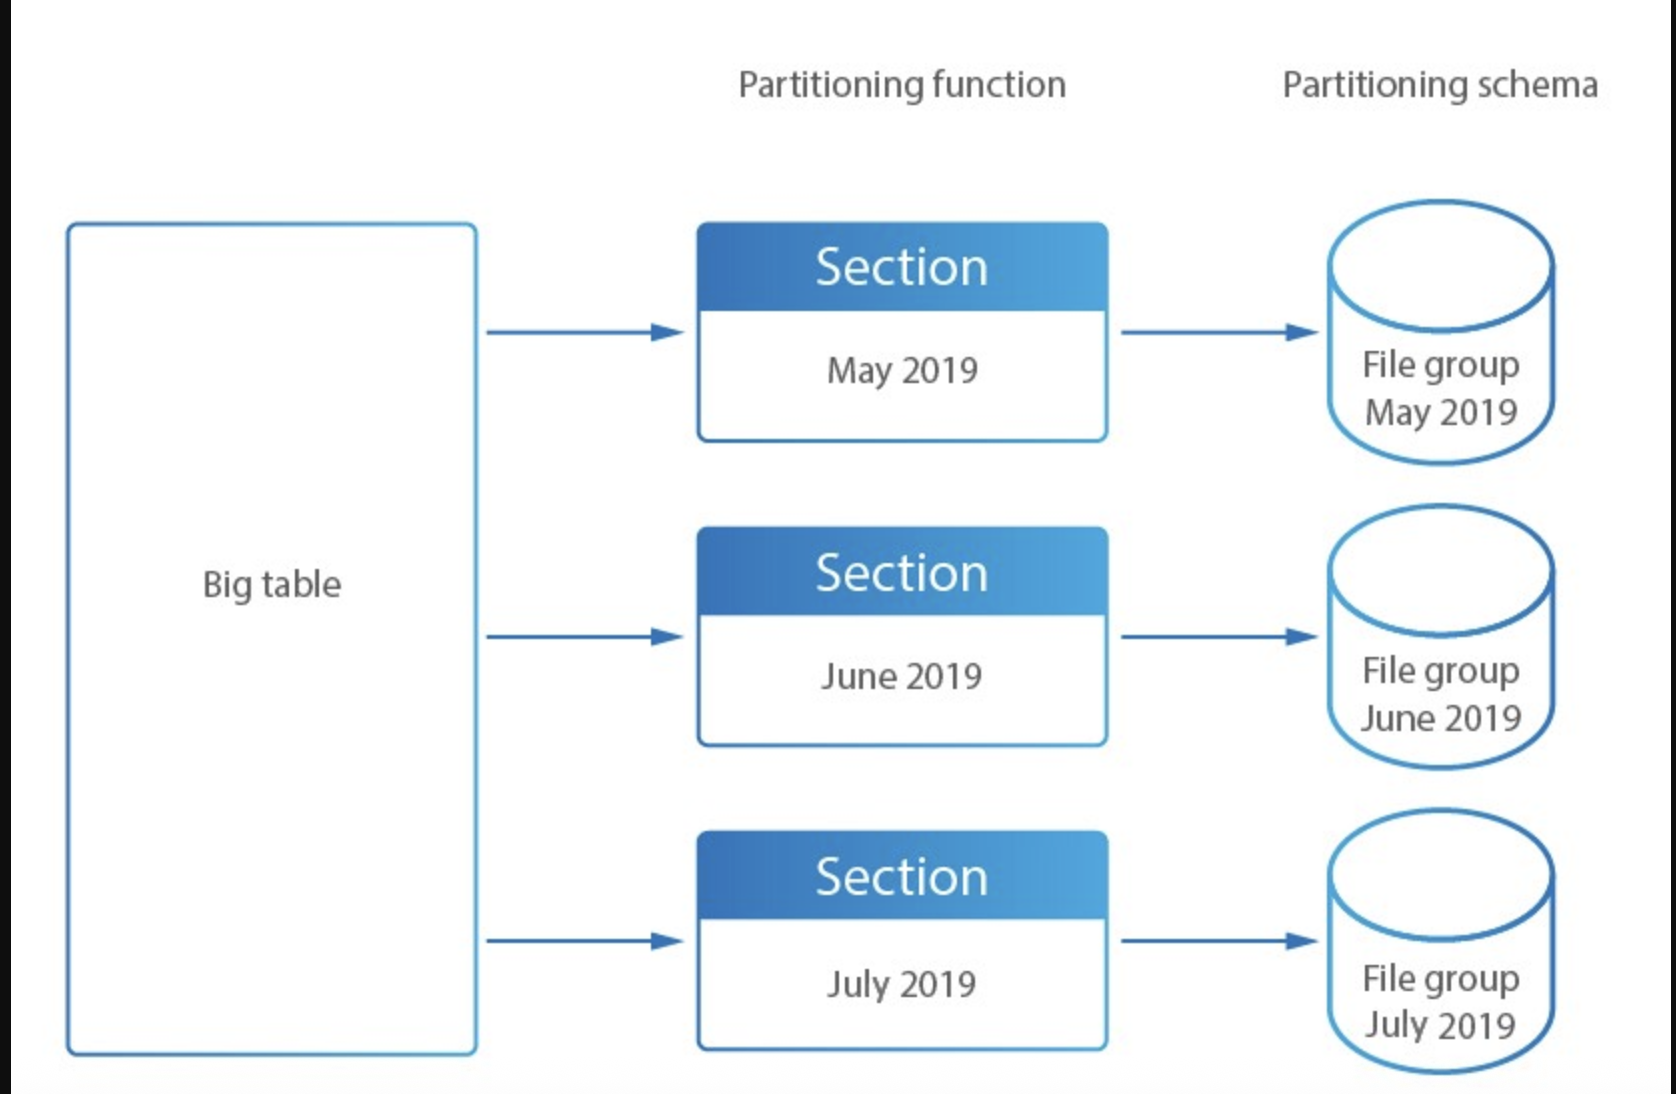
[pic](https://www.datasunrise.com/wp-content/uploads/2019/09/Partitioning-1.jpg)

### Pros
- Query performance
- Parallel query execution
- Better for time-series data

### Cons
- Increased complexity
- Queries without partition key scan all partitions
- Hard to change partition strategy

### When to Use
- Large tables (>100GB)
- Clear access patterns by date/region/category
- Time-series or log data

### When NOT to Use
- Small tables (<50GB)
- Unpredictable query patterns
- Need flexibility in querying



## 6. Sharding
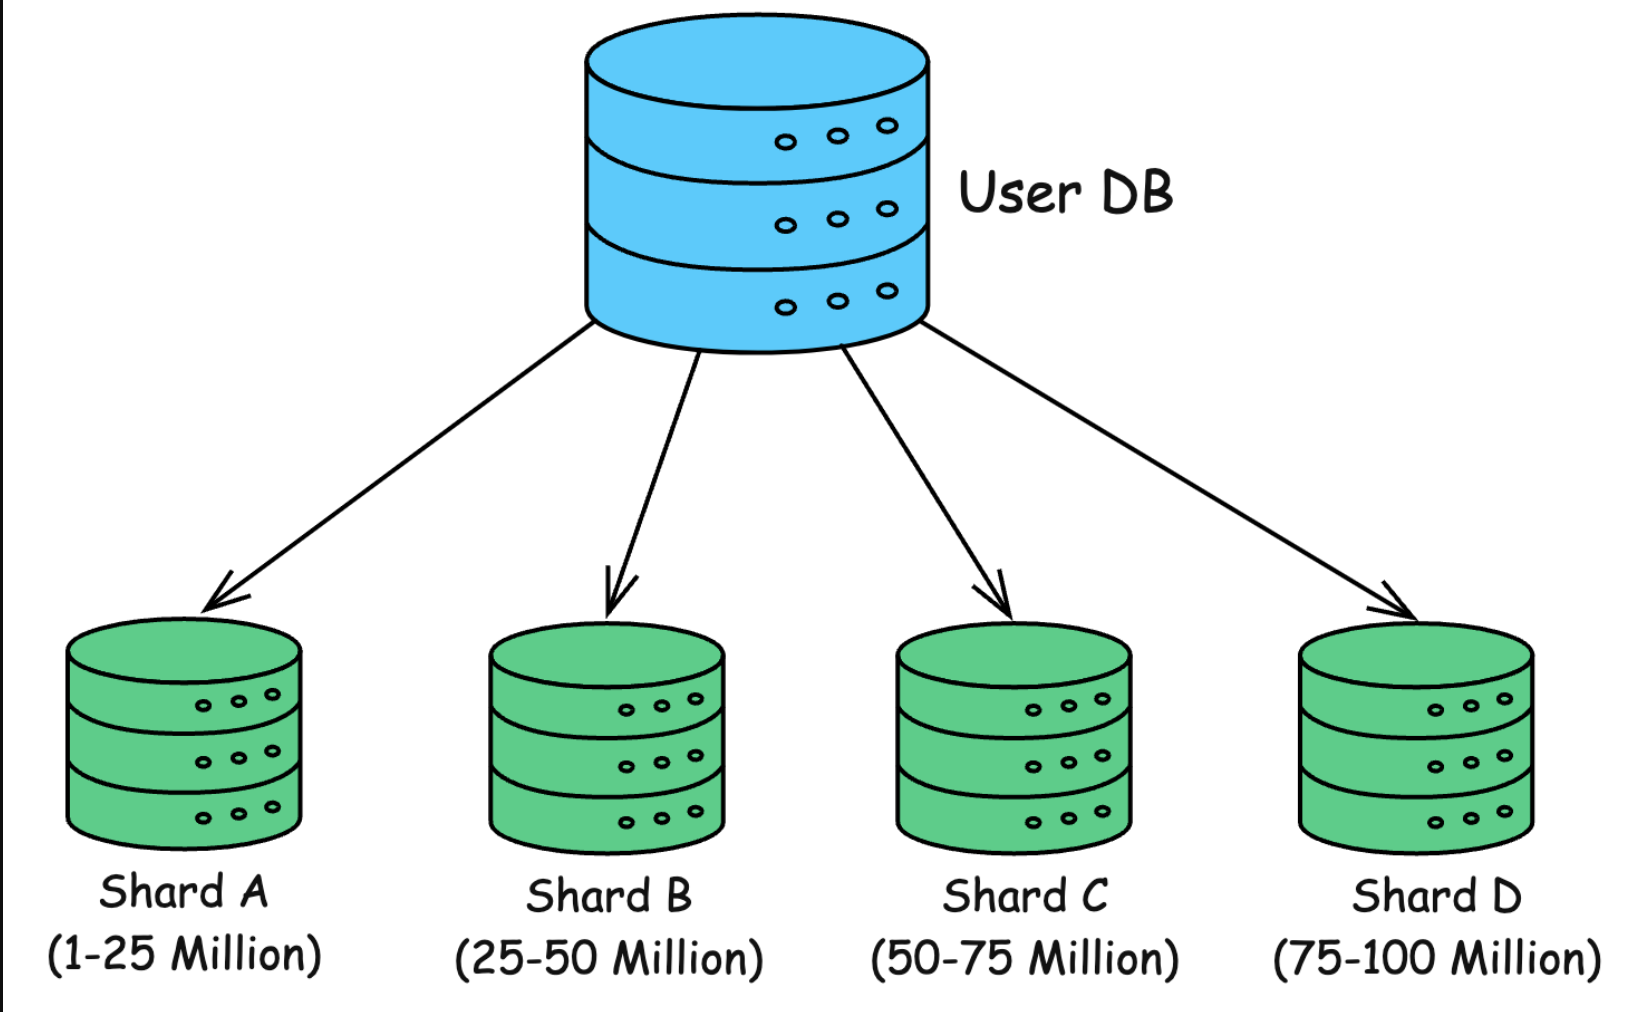
[pic](https://substackcdn.com/image/fetch/$s_!vnZu!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F9a8944df-ac2d-4554-be29-bfcb4edcb0c7_1474x1036.png)


### Pros
- Massive scalability (nearly unlimited horizontal scaling)
- Linear scaling for reads AND writes
- Parallel query execution across shards
- Fault isolation (one shard failure doesn't take down entire system)

### Cons
- Massive complexity (application, deployment, operations)
- Cross-shard queries are painful
- No distributed transactions (ACID across shards is hard)
- Aggregations are expensive (query all shards)
- Uneven data distribution (hot shards)
- Rebalancing is HARD (adding/removing shards)
- Can't go back (one-way door decision)

### When to Use
- Massive scale (multi-TB data, 100K+ QPS, hundreds of millions of users)
- Clear, clean shard key (tenant_id, user_id, device_id)
- Write-heavy workload (single database bottlenecked on writes)
- Isolation requirements (enterprise customers, security, performance tiers)

### When NOT to Use
- Premature optimization (database <1TB, <50K QPS)
- No clear shard key (queries filter on different columns)
- Lots of cross-shard queries needed (JOINs, global searches, aggregations)
- Complex transactions (financial transfers, multi-step workflows, need ACID)
- Limited budget (sharding requires significant infrastructure + ops cost)
- Rapid schema changes (startup iterating quickly, finding product-market fit)


## Decision Tree
```text
Query is slow?
└─ Add indexes

Database CPU high from reads?
└─ Add read replicas

Same queries repeated frequently?
└─ Add caching
└─ Materialized views

Table very large (>100GB)?
└─ Add partitioning

Need more capacity but not at limits?
└─ Vertical scaling (Increase machine capacity)

Still hitting limits after all above?
└─ Consider sharding (last resort) 
```


## 7. others:
   - Avoid SELECT *
   - Use JOINs efficiently
   - Always join on indexed columns and avoid unnecessary JOINs.
   - Filter early using WHERE
   - Push filters down so the database processes fewer rows.
   - Use LIMIT for large tables

# view vs materialized view vs table
## Table  
- A physical storage of data. Real rows exist on disk.
- Use case: store actual business data.

## View
- A saved SQL **query**. No data stored; computed every time I query it.  
- Use case: simplify complex queries; always shows fresh data
```sql
CREATE VIEW high_value_orders AS
SELECT * FROM orders WHERE amount > 1000;
```

## Materialized View
- A view that stores the **query result** physically. Faster than a view.
- **Must be refreshed** manually or on a schedule.
- Use case: heavy aggregation queries that **don’t need real-time freshness**.
```sql
CREATE MATERIALIZED VIEW daily_sales AS
SELECT date, SUM(amount) 
FROM orders 
GROUP BY date;
```


# NoSQL
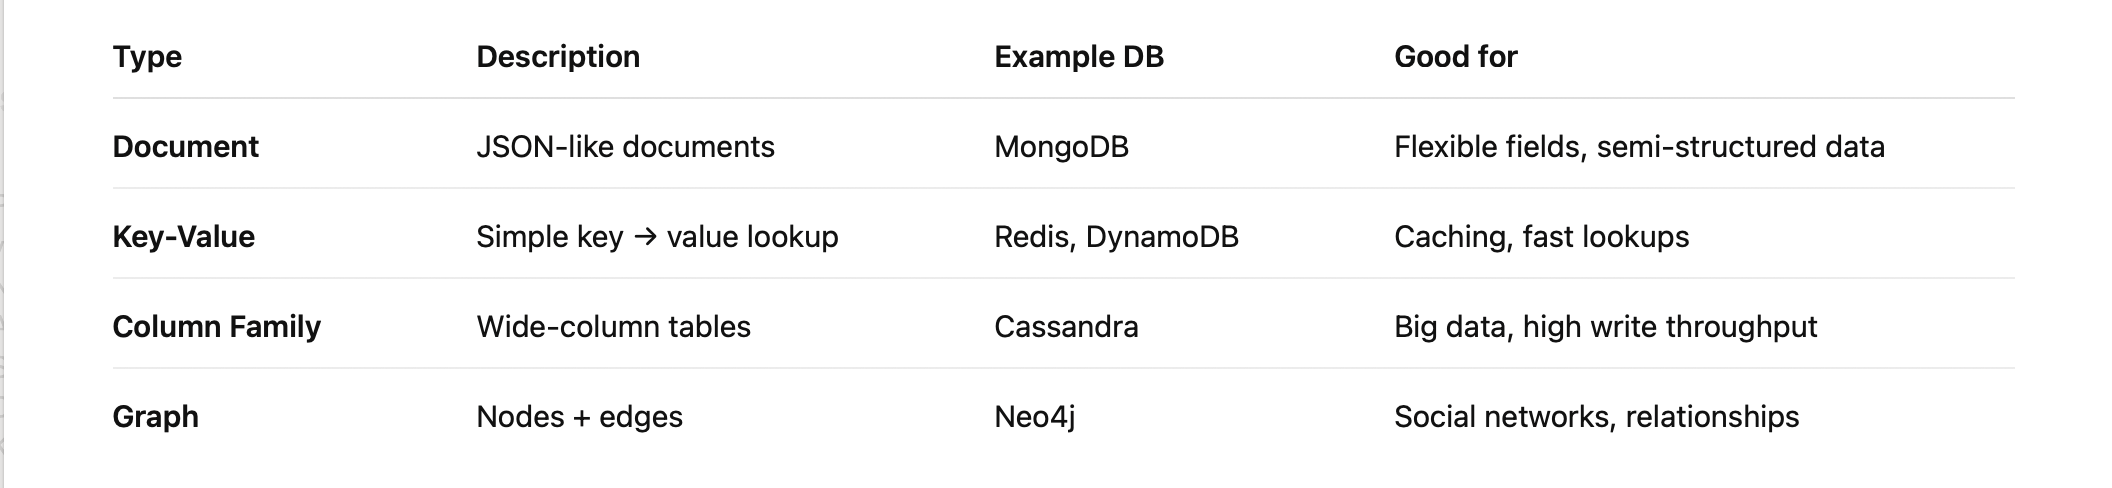


## Document databases
### MongoDB (CP)
stores data as BSON documents (similar to JSON).  
Each document can have different fields, so flexible schema.
```json
{
  "name": "Yannis",
  "skills": ["Python", "SQL"],
  "age": 25
}
```
Good use cases: 
- User profiles  
- Product catalogs
- Log/event data
- blog post
- Flexibly structured data, each item has different fields

#### MongoDB & ACID
Early MongoDB (pre-4.0):

- ✅ Single-document ACID (always had this)
- ❌ No multi-document transactions
- This limited its use for traditional transactional workloads

MongoDB 4.0+ (2018):

- ✅ Single-document ACID
- ✅ Multi-document ACID transactions (replica sets)

MongoDB 4.2+ (2019):

- ✅ Multi-document ACID transactions (sharded clusters)

Since MongoDB 4.0+, it added full multi-document ACID transactions. So now:
- Single-document operations are ALWAYS ACID
(because documents are the natural unit of atomicity)
- Multi-document transactions are supported, but they come with performance overhead and are not meant to replace SQL-style relational patterns.
1. ACID in MongoDB (Simple Breakdown)  

A — Atomicity   
	•	A single document write (insert/update/delete) is atomic even if the document is huge.   
	•	Multi-document transactions (like SQL) are atomic since 4.0.    

C — Consistency      
	•	MongoDB enforces schema rules via:    
	•	document validation    
	•	unique indexes      
	•	foreign key–like references (manually enforced)    
	•	Transactions ensure the database moves from one valid state to another.     

I — Isolation       

MongoDB uses snapshot isolation:      
	•	Reads inside a transaction always see a consistent snapshot of data.        
	•	No dirty reads, no partial writes.      

D — Durability    
	•	Journaling ensures that once a write is committed, it survives crashes.    
	•	Write concern "w: majority" ensures the data is written to multiple replicas. 

2. How MongoDB Transactions Work Internally     

MongoDB supports two types:     

✔️ Single-document transactions (default, always ACID)    

This is the most common.   
MongoDB optimizes for embedding related data into a single document.      

✔️ Multi-document transactions (like SQL)    

Introduced in MongoDB 4.0 for replica sets and in 4.2 for sharded clusters.      

How they work:      
	•	Use a multi-statement session    
	•	All writes are staged     
	•	The whole batch is committed atomically     
	•	On failure, the entire transaction rolls back     

3. When MongoDB Transactions Are Needed     

You need multi-document transactions when:      
	•	Updating related documents in different collections (SQL-style normalization)      
	•	Financial operations: balances, transfers     
	•	Workflows requiring strong consistency across collections   

### Couchbase
Mobile app data syncing, content management systems

## Key-value databases 
### Redis 
stores data as simple key → value pairs.
```text
user123 → {"name": "Chengyang", "score": 99}
session_token → "af3k9x92"
```
Good use cases:
	- Caching (fastest reads)
	- Session storage
	- Rate limiting
	- Message queues (using Redis streams)
	- real-time leaderboards

### DynamoDB (AP)
User sessions, shopping carts, game state storage

## Column-family databases:

### Cassandra (AP)
Time-series data like sensor readings, activity logs, messaging history  

key: no master node, so no primary, so it is ap


### HBase
Large-scale analytics, storing massive datasets that need fast writes

## Graph databases:

Neo4j - Social networks, recommendation engines, fraud detection
Amazon Neptune - Knowledge graphs, identity management, network analysis

## Common patterns:

- Use Redis when you need to read something super fast and temporary
- Use MongoDB when your data looks like JSON and changes structure often
- Use Cassandra when you're writing tons of time-stamped data
- Use Neo4j when relationships between things matter more

## SQL vs NoSQL decision criteria

**Choose SQL when**:
- ACID
- You need data to be correct and consistent (like bank accounts, shopping carts)
- Your data connects together in clear ways (users have orders, orders have products)
- You need to run complicated searches and reports on your data
- Your data structure won't change much over time

Example: banking, inventory, ERP systems

**Choose NoSQL when:**
- You need to handle huge amounts of data across many servers
- Your data doesn't fit into neat tables or changes shape a lot
- Speed matters more than having the absolute latest data (like social media posts)
- You mostly look up one thing at a time by its ID

Example: IoT data, social media posts, logs
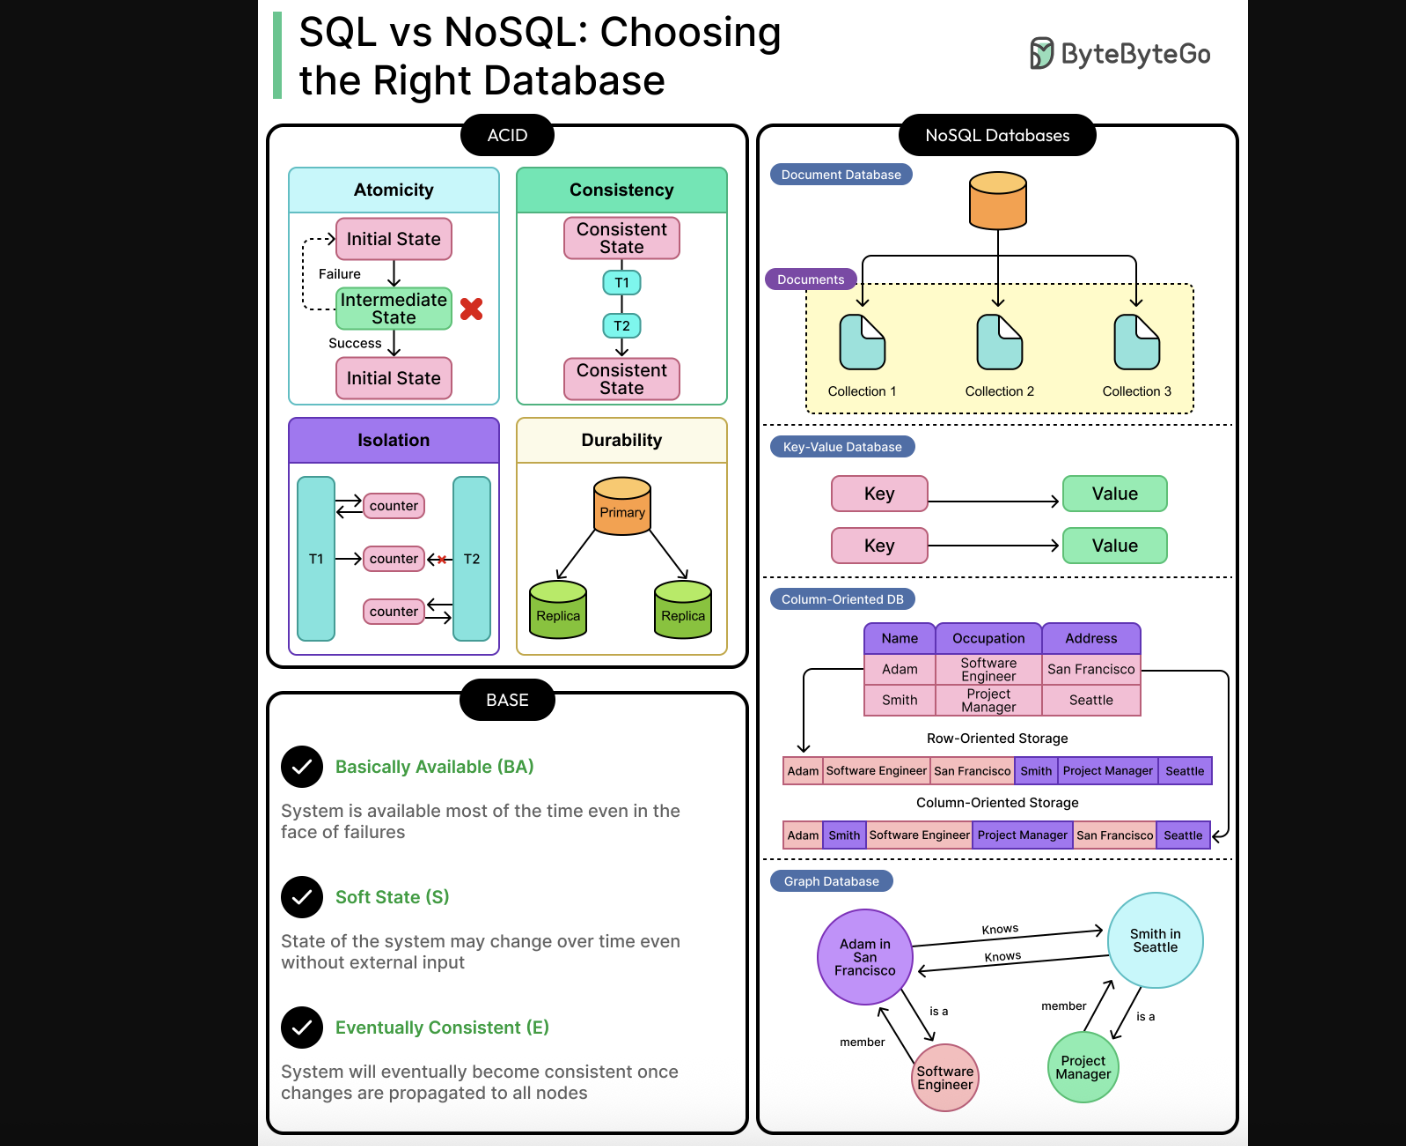
[pic](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fad3cb281-2af9-436e-b474-f697368a2049_2250x2624.png)
